In [1]:
import os
import json
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils import data
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from pycocotools.coco import COCO
import cv2

NOTE! Installing ujson may make loading annotations faster.


In [2]:
from engine.data.datasets.city_sdd import Cityscapes, collate_fn
from engine.data import transform_sdd as transform

In [3]:
data_dir = "/usr/src/EXP_template/cityscapes"
value_scale = 255
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean = [item * value_scale for item in mean]
std = [item * value_scale for item in std]

dataset = Cityscapes(
    data_root=data_dir,
    split="val",
    # ignore_label=self.ignore_label,
    transforms=transform.Compose([ #% init에 parameter 추가
        transform.RandScale((0.5,2)),
        transform.RandomHorizontalFlip(p=0.5),
        transform.Crop((768,1536), crop_type='rand', padding=mean),
        transform.ToTensor(),
        transform.Normalize(mean=mean, std=std)
        ]),)

loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


In [4]:
dataloader_kwargs = {"num_workers": 4,
                    "pin_memory": True,
                    "batch_size": 2,
                    "drop_last": True,
                    "shuffle": False,
                    "collate_fn": collate_fn}
train_loader = torch.utils.data.DataLoader(dataset, **dataloader_kwargs)

In [5]:
itt = iter(train_loader)

In [6]:
img, tar = next(itt)

In [21]:
for i in range(len(tar)):
    print(tar[i]['limg'].shape, tar[i]['rimg'].shape, tar[i]['rimg_tf'].shape, tar[i]['lseg'].shape)

torch.Size([3, 1024, 2048]) torch.Size([3, 1024, 2048]) torch.Size([3, 768, 1536]) torch.Size([768, 1536])
torch.Size([3, 1024, 2048]) torch.Size([3, 1024, 2048]) torch.Size([3, 768, 1536]) torch.Size([768, 1536])
torch.Size([3, 1024, 2048]) torch.Size([3, 1024, 2048]) torch.Size([3, 768, 1536]) torch.Size([768, 1536])
torch.Size([3, 1024, 2048]) torch.Size([3, 1024, 2048]) torch.Size([3, 768, 1536]) torch.Size([768, 1536])


In [22]:
limgs = torch.stack([b['limg'] for b in tar])
rimg = torch.stack([b['rimg'] for b in tar])
rimg_tf = torch.stack([b['rimg_tf'] for b in tar])
lseg = torch.stack([b['lseg'] for b in tar])
print( limgs.shape, rimg.shape,  rimg_tf.shape, lseg.shape)

torch.Size([4, 3, 1024, 2048]) torch.Size([4, 3, 1024, 2048]) torch.Size([4, 3, 768, 1536]) torch.Size([4, 768, 1536])


In [7]:

from engine.exp import get_exp

In [8]:
exp = get_exp('exps/citytest_sdd.py', None) #% engine.exp.build


In [9]:
model = exp.get_model()

In [10]:
import torch
model.train().cuda()

Fullmodel(
  (backbone): CSPDarkNet(
    (stem): Sequential(
      (0): BaseConv(
        (conv): Conv2d(3, 64, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    )
    (B4): Sequential(
      (0): BaseConv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): BottleneckCSP(
        (cv1): BaseConv(
          (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (cv3): Conv2d(64, 64, kernel_size=(1, 1), str

In [11]:
rimg = torch.stack([b['rimg'] for b in tar]).cuda()
limg = torch.stack([b['limg'] for b in tar]).cuda()
inps = torch.cat([limg, rimg])

outputs = model(inps, tar)

backbone clear
backbone_features 5
backbone feature len :  6
f64_upscale shape : torch.Size([4, 512, 32, 64])
f32 shape : torch.Size([4, 512, 32, 64])


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 11.78 GiB total capacity; 10.39 GiB already allocated; 19.25 MiB free; 10.44 GiB reserved in total by PyTorch)

In [16]:
tar[0]['limg'].shape

(1024, 2048, 3)

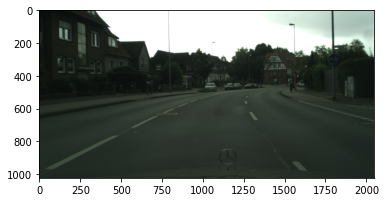

In [24]:
plt.imshow(torch.from_numpy(tar[0]['limg']))

In [8]:
img.shape

torch.Size([4, 3, 768, 1536])

In [11]:
for aa in tar:
    print(aa.keys())
    print(aa['img_id'])

dict_keys(['limg', 'rimg', 'lseg', 'rseg', 'ldet', 'img_size', 'img_id'])
[2975]
dict_keys(['limg', 'rimg', 'lseg', 'rseg', 'ldet', 'img_size', 'img_id'])
[2976]
dict_keys(['limg', 'rimg', 'lseg', 'rseg', 'ldet', 'img_size', 'img_id'])
[2977]
dict_keys(['limg', 'rimg', 'lseg', 'rseg', 'ldet', 'img_size', 'img_id'])
[2978]


In [ ]:
class_ids

[1, 2, 3, 4, 5, 6, 7, 8]

In [7]:
jsonPath =  '/usr/src/EXP_template/cityscapes' + '/annotations/cityscapes_to_coco_' + 'val' + '.json'
city = COCO(jsonPath)
img = Image.open( '/usr/src/EXP_template/cityscapes/'+file_name.replace('leftImg8bit','rightImg8bit'))
aa = '/usr/src/EXP_template/cityscapes/'+file_name.replace('leftImg8bit','rightImg8bit')


loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


NameError: name 'file_name' is not defined

In [ ]:
seg_path = aa.replace('rightImg8bit', 'gtFine',1).replace('rightImg8bit','gtFine_labelIds',1)
seg_cv = cv2.imread(seg_path,cv2.IMREAD_GRAYSCALE)                           
seg_np = Image.open(seg_path)
seg_np = np.asarray(seg_np)
np.array_equal(seg_cv,seg_np)

img_cv = cv2.imread(aa)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
img_np = Image.open(aa)
img_np = np.asarray(img_np)
np.array_equal(img_cv,img_np)

In [4]:
jsonPath =  '/usr/src/EXP_template/cityscapes' + '/annotations/cityscapes_to_coco_' + 'val' + '.json'
city = COCO(jsonPath)

loading annotations into memory...
Done (t=0.97s)
creating index...
index created!


In [5]:
ids = city.getImgIds()
id_ = ids[1]

In [6]:

im_ann = city.loadImgs(id_)[0]
width = im_ann["width"]
height = im_ann["height"]
anno_ids = city.getAnnIds(imgIds=[int(id_)], iscrowd=False)
annotations = city.loadAnns(anno_ids)

In [7]:
objs = []
#TODO: check annotation. 아래는 annotation이 x1,y1,w,h로 되어있는 경우를 가정하고 작성한 것.
for obj in annotations: 
    x1 = np.max((0, obj["bbox"][0]))
    y1 = np.max((0, obj["bbox"][1]))
    x2 = np.min((width, x1 + np.max((0, obj["bbox"][2]))))
    y2 = np.min((height, y1 + np.max((0, obj["bbox"][3]))))
    if obj["area"] > 0 and x2 >= x1 and y2 >= y1:
        obj["bbox"] = [x1, y1, x2, y2] #TODO: dict 키가 clean box인지, bbox인지 확인.
        objs.append(obj)

In [10]:
objs[0].keys()

dict_keys(['id', 'image_id', 'segmentation', 'category_id', 'iscrowd', 'area', 'bbox', 'boxes'])

In [9]:
bbox, labels, area = list(), list(), list()
for obj in objs:
    bbox.append(obj['bbox'])
    labels.append(obj['category_id'])
    area.append(obj['area'])
res = {'boxes': torch.as_tensor(bbox, dtype=torch.float32).reshape(-1, 4),
        'labels': torch.tensor(labels, dtype=torch.int64),
        'area': torch.tensor(area, dtype=torch.float32),}


{'id': 50359,
 'image_id': 2976,
 'segmentation': [[756,
   422,
   755,
   423,
   754,
   424,
   754,
   425,
   754,
   426,
   753,
   427,
   753,
   428,
   753,
   429,
   754,
   430,
   754,
   431,
   754,
   432,
   755,
   433,
   755,
   434,
   755,
   435,
   756,
   436,
   756,
   437,
   756,
   438,
   756,
   439,
   756,
   440,
   757,
   441,
   757,
   442,
   758,
   442,
   759,
   442,
   760,
   441,
   760,
   440,
   760,
   439,
   761,
   438,
   761,
   437,
   761,
   436,
   761,
   435,
   761,
   434,
   761,
   433,
   761,
   432,
   761,
   431,
   761,
   430,
   761,
   429,
   761,
   428,
   761,
   427,
   761,
   426,
   761,
   425,
   761,
   424,
   760,
   423,
   759,
   422,
   758,
   422,
   757,
   422]],
 'category_id': 1,
 'iscrowd': 0,
 'area': 141,
 'bbox': [753, 422, 9, 21],
 'boxes': [753, 422, 762, 443]}

In [ ]:
for 